# FrostAway Prediction Method

FrostAway prediciton method is based on Neural Network that take the spatio-temporal information of the guardians. The models is based on Graph Neural Networks as base framework.

With the usage of Graph Attentional Networks and Recurrent units the model predicts the relevant environmental conditions of the protection site.

In [1]:
# # Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# instalation of dependencies
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install git+https://github.com/TorchSpatiotemporal/tsl.git
!pip install pytorch-lightning


2.4.1+cu121
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-zy274scb
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-zy274scb
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 56d53d03a7326c7882d33345a759df1b02bcb4f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/TorchSpatiotemporal/tsl.git to /tmp/pip-req-build-ygazb_nc
  Running command git clone --filter=blob:none --quiet https://github.com/TorchSpatiotemporal/tsl.git /tmp/pip-req-build-ygazb_nc
  Resolved https://github.com/TorchSpatiotemporal/tsl.git to commit f9e5081d198cc4e568a41b0ba472fce0f603c61b
  Preparing metadata (setup.py) ... done


The model is based on the pytorch neural network and machine learning framework. With the usage of the torch-spatiotemporal learning package we laverage different techniques from the Network science and Machine Learning to take into account the interaction between the variables in the different nodes (gaurdians) in the protection area.

In [2]:
import tsl
import torch
import numpy as np
import pandas as pd
from tsl.datasets import MetrLA
from tsl.ops.connectivity import edge_index_to_adj
from tsl.data import SpatioTemporalDataset
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler
import torch.nn as nn

from tsl.nn.blocks.encoders import RNN
from tsl.nn.layers import NodeEmbedding, DiffConv
from einops.layers.torch import Rearrange  # reshape data with Einstein notation

from tsl.metrics.torch import MaskedMSE, MaskedMAPE
from tsl.engines import Predictor

from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from tsl.data import Data

import matplotlib.pyplot as plt
import pandas as pd

import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime
import itertools
import numpy as np
import torch
from scipy.spatial.distance import cdist

The model is pre-trained with satelital data from the Meteomatics API. The models uses satelital historical data to generate a set of parameters that is going to be further used to train a local model based on the guardians data.

The data is obtained from the geographical location using the coordinates as inputs for the functions

In [3]:
def get_climate_data(start_date, end_date, lat, lon):
    """
    Function to get climate data from the Meteomatics API
    :param start_date: Start date of the data in format YYYY-MM-DD
    :param end_date: End date of the data in format YYYY-MM-DD
    :param lat: Latitude of the location in decimal degrees with dot
    :param lon: Longitude of the location in decimal degrees with dot
    :return: Dataframe with the climate data
    """
    payload = {"inUserName": "militzer_maximiliano", "inUserPass": "2ji2WoYD2h"}
    location = f"{lat},{lon}"

    # Transform the dates to the correct format

    # Get Temperature above 2 meters, pressure, wind above 10 meters and humidity
    data_params = "t_2m:C,sfc_pressure:psi,wind_speed_10m:kmh,relative_humidity_2m:p"

    # Get the data from the API
    response = requests.get(
        f"https://api.meteomatics.com/{start_date}T00:00:00Z--{end_date}T00:00:00Z:PT1H/{data_params}/{location}/json",
        auth=HTTPBasicAuth(payload["inUserName"], payload["inUserPass"]),
    )
    return response.json()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

def nsew_to_lat_long(coordinates):
    split = coordinates.split(' ')
    ns = (split[0].strip('°'))
    if 'S' in ns:
        ns = '-' + ns
    ew = (split[1].strip('°'))
    if 'W' in ew:
        ew = '-' + ew
    latitude = ns[:-2]
    longitude = ew[:-2]
    return float(latitude), float(longitude) # latitude, longitud


def scrap_json(json_meteomatics):
    data = json_meteomatics['data']

#   out_meteo = pd.DataFrame(columns = ['Date', 't_2m:C','sfc_pressure:psi', 'wind_speed_10m:kmh','relative_humidity_2m:p'])
    merge_original = pd.DataFrame()
    for i in data:
        parameter = i['parameter']
        dates = pd.DataFrame.from_dict(i['coordinates'][0]['dates'])
        dates.rename(columns = {'value':f'{parameter}'}, inplace = True)
        # print(dates)
        if merge_original.empty:
            merge_original = dates
        else:
            merge_original = merge_original.merge(dates ,on = 'date')
    return merge_original

def get_weather_batch(
    coords: list,
    start_d: str,
    end_d: str
) -> list:
    list_weather = []
    for coorde in coords:
        lat, lon = nsew_to_lat_long(coorde)

        json_meteo = get_climate_data(start_d, end_d, lat, lon)
        df_w = scrap_json(json_meteo)

        list_weather.append(df_w)
    # print(list_weather)
    return list_weather

def gen_weight_matrix(list_coords: list) -> pd.DataFrame:
    n_nodes = [f'node_{i+1}' for i in range(len(list_coords))]

    distance_matrix = pd.DataFrame(0, columns=n_nodes, index = n_nodes, dtype = float)
    for i, j in itertools.combinations(n_nodes,2):
        index = int(i.split('_')[1])-1
        index2 = int(j.split('_')[1])-1
        coord1 = np.array([nsew_to_lat_long(list_coords[index])])
        coord2 = np.array([nsew_to_lat_long(list_coords[index2])])

        distance_matrix.at[i,j] = 1/cdist(coord1, coord2)
        distance_matrix.at[j,i] = distance_matrix.loc[i, j]
    return distance_matrix

def format_result(list_df,
                  map_channel):
    list_nodes = np.arange(1, len(list_df)+1)
    list_parameters = np.arange(1, len(list_df[0].columns[1:])+1)
    list_two_col = list(itertools.product(list_nodes, list_parameters))
    t = len(list_df[0].index)
    n = len(list_nodes)
    f = len(list_parameters)
    tensor_results = torch.zeros([t,n ,f])
    for i in list_nodes:
        print(i)
        print(list_df[i-1].iloc[:, 1:])
        tensor_results[:, i-1, :] = torch.tensor(list_df[i-1].iloc[:, 1:].values)
    return tensor_results




def distance_to_connectivity(distance_matrix):
    edges = []
    edges_w = []

    for i, j in itertools.combinations(distance_matrix.columns, 2):
        i_index = int(i.split('_')[1])-1
        j_index = int(j.split('_')[1])-1
        edges.append([i_index,j_index])
        edges_w_value = distance_matrix.loc[i,j]
        edges_w.append(edges_w_value)

    return torch.tensor(edges).T, torch.tensor(edges_w)


The model only needs as input the coordinates where the guardians are meant to be installed. This coordinates allow the system to extract historical data of the location to pre-trained the model weights.

In [4]:
# proof-of-concept coordinates
pin1 = '34.455737°S 70.925231°W'
pin2 = '34.452217°S 70.920077°W'
pin3 = '34.454563°S 70.911596°W'
pin4 = '34.457393°S 70.908903°W'
pin5 = '34.460729°S 70.914312°W'
pin6 = '34.456189°S 70.916805°W'
coords = [
    pin1,
    pin2,
    pin3,
    pin4,
    pin5,
    pin6
]
# proof-of-concept temporal window to analyze
start_date = "2021-05-01"
end_date = "2024-03-01"

# Get the weather data using a scrapper using the meteomatics API
w_list = get_weather_batch(coords,
                            start_d=start_date,
                            end_d=end_date)

# calculate weight matrix from the 1/distance of the guardians using the geographical coordinates
distance_matrix = gen_weight_matrix(coords)
# get connectivity of the guardians using a fully connected graph
edges, edges_w = distance_to_connectivity(distance_matrix)

# generate a tensor containing all the information to analyze the system
# this is to get the format needed to trian the model
channels_tens = format_result(w_list,
                            map_channel={
                                1: 't_2m:C',
                                2: 'relative_humidity_2m:p',
                                3: 'wind_speed_10m:kmh',
                                4: 'sfc_pressure:psi'
                            })
# Get the date that are going to be used in the model
time = w_list[0].date

1
       t_2m:C  sfc_pressure:psi  wind_speed_10m:kmh  relative_humidity_2m:p
0        13.3           14.3360                 4.7                    80.3
1        13.7           14.3321                 2.9                    77.0
2        12.9           14.3457                 4.2                    81.1
3        12.5           14.3413                 2.5                    82.7
4        12.0           14.3368                 4.4                    87.5
...       ...               ...                 ...                     ...
24836    32.4           14.2515                10.4                    26.2
24837    31.9           14.2528                 9.4                    26.7
24838    30.6           14.2540                 7.9                    30.2
24839    27.1           14.2583                 7.3                    40.8
24840    24.1           14.2651                 4.9                    45.9

[24841 rows x 4 columns]
2
       t_2m:C  sfc_pressure:psi  wind_speed_10m:kmh  relat

# Data Structure
The data structure is particular to a geometric form. This is why we follow the guidelines of the torch-spatiotemporal documentation [Data structure](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/data_structures.html) and [SpatioTemporalDataset Structure](https://torch-spatiotemporal.readthedocs.io/en/latest/usage/spatiotemporal_dataset.html)

In [29]:
tens = len(channels_tens[:,1,1])
inp = {
 'x' : channels_tens[:,:,:]
}

target = {
    'y': channels_tens[:, :,1]
}
pattern = {'x':'t n f', 'y' : 't n'}
data_model = Data(
    input = inp,
    target = target,
    has_mask=False,
    pattern = pattern,
    edge_index=edges,
    edge_weight = edges_w,
    dist = distance_matrix
)

In [30]:
torch_dataset = SpatioTemporalDataset(target=data_model.input.x,
                                      connectivity=(edges, edges_w),
                                      mask = None,
                                      index = time,
                                      horizon=24,
                                      window=24*4,
                                      stride=1)

# Model training

The model training is done using pytorch-lightning which allows for the model to be trained with ease and it has a good connection with torch-spatiotemporal

In [31]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
from tsl.data.preprocessing import StandardScaler

# Normalize data using mean and std computed over time and node dimensions
scalers = {'target': StandardScaler(axis=(0, 1))}

# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=splitter,
    batch_size=64,
)
# set up the datasets training, validation and test
dm.setup()
print(dm)

SpatioTemporalDataModule(train_len=17705, val_len=1881, test_len=4944, scalers=[target], batch_size=64)


## Model structure

The model is structured such that takes into account spatial and temporal information with a SpatioTemporalTransformerLayer with multihead attention mechanism.

The graph structure of the data needs to be taked into account, therefore a node embeding is done to analyze the nodes too. Furthermore, a Recurrent unit is used with a graph recurrent  unit as a base unit. And a Diffusion Convolution is

In [32]:
# Install necessary packages

import torch
from tsl.nn.blocks.encoders import RNN, SpatioTemporalTransformerLayer
from tsl.nn.layers.graph_convs import GATConv
# Import torch explicitly

class WeatherGraph(nn.Module):
    def __init__(self, input_size: int, n_nodes: int, horizon: int,
                 hidden_size: int = 32,
                 rnn_layers: int = 1,
                 gnn_kernel: int = 2):
        super(WeatherGraph, self).__init__()

        self.encoder = SpatioTemporalTransformerLayer(input_size, hidden_size, ff_size = 1,
                                                      n_heads = 2, dropout = 0.01)

        self.node_embeddings = NodeEmbedding(n_nodes, hidden_size)

        self.time_nn = RNN(input_size=hidden_size,
                           hidden_size=hidden_size,
                           n_layers=rnn_layers,
                           cell='gru',
                           return_only_last_state=True,
                           dropout = 0.01)

        # self.space_nn = DiffConv(in_channels=hidden_size,
        #                          out_channels=hidden_size,
        #                          k=gnn_kernel)

        self.decoder = nn.Linear(hidden_size, input_size * horizon)
        self.rearrange = Rearrange('b n (t f) -> b t n f', t=horizon)

    def forward(self, x, edge_index, edge_weight):
        # x: [batch time nodes features]
        edge_index = edge_index  # Convert edge_index to np.int64 before creating tensor

        # Check for NaN or Inf in edge_weight and replace them with 0
        edge_weight = torch.nan_to_num(edge_weight, nan=0.0, posinf=0.0, neginf=0.0)

        # print(f"Shape of x before encoder: {x.shape}")

        x_enc = self.encoder(x)  # linear encoder: x_enc = xΘ + b
        x_emb = x_enc + self.node_embeddings()  # add node-identifier embeddings
        h = self.time_nn(x_emb)  # temporal processing: x=[b t n f] -> h=[b n f]

        # Try converting edge_weight to float32
        # z = self.space_nn(h, edge_index, edge_weight.float())  # spatial processing
        # if isinstance(z, tuple):
        #     z = z[0]

        x_out = self.decoder(h)  # linear decoder: z=[b n f] -> x_out=[b n t⋅f]
        x_horizon = self.rearrange(x_out)
        return x_horizon

In [33]:
torch_dataset[0].input

StorageView(x=[96, 6, 4], edge_index=[2, 15], edge_weight=[15])

In [34]:
hidden_size = 32
rnn_layers = 2
gnn_kernel = 2

input_size = torch_dataset.n_channels  # 3 channel
n_nodes = torch_dataset.n_nodes         # 6 nodes
horizon = torch_dataset.horizon         # 24 time steps
output_size = input_size

stgnn = WeatherGraph(input_size=input_size,
                           n_nodes=n_nodes,
                          #  output_size = output_size,
                           horizon=horizon,
                           hidden_size=hidden_size,
                           rnn_layers=rnn_layers,
                           gnn_kernel=gnn_kernel)
print(stgnn)
print_model_size(stgnn)

WeatherGraph(
  (encoder): SpatioTemporalTransformerLayer(
    (temporal_att): MultiHeadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      (q_proj): Linear(4, 32, bias=True)
    )
    (spatial_att): MultiHeadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      (q_proj): Identity()
    )
    (skip_conn): Linear(in_features=4, out_features=32, bias=True)
    (norm1): LayerNorm(4)
    (norm2): LayerNorm(32)
    (mlp): Sequential(
      (0): LayerNorm(32)
      (1): Linear(in_features=32, out_features=1, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.01, inplace=False)
      (4): Linear(in_features=1, out_features=32, bias=True)
      (5): Dropout(p=0.01, inplace=False)
    )
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (node_embeddings): NodeEmbedding(n_nodes=6, embedding_size=32)
  (time_nn): RNN(
    (rnn): GRU(32, 32, num_layers=2, dropout=0.01)
  )


In [35]:

loss_fn = MaskedMSE()

metrics = {'mse': MaskedMSE(),
           'mse_at_2': MaskedMSE(at=2),  # '2' indicates the third time step,
                                          # which correspond to 15 minutes ahead
           'mse_at_10': MaskedMSE(at=10),
           'mse_at_12': MaskedMSE(at=12),
           'mse_at_20': MaskedMSE(at=20),
           'mse_at_24': MaskedMSE(at=2)}

# setup predictor
predictor = Predictor(
    model=stgnn,                   # our initialized model
    optim_class=torch.optim.Adam,  # specify optimizer to be used...
    optim_kwargs={'lr': 0.001},    # ...and parameters for its initialization
    loss_fn=loss_fn,               # which loss function to be used
    metrics=metrics                # metrics to be logged during train/val/test
)

In [36]:
dm.trainset[0].input

StorageView(x=[96, 6, 4], edge_index=[2, 15], edge_weight=[15])

In [37]:
checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mse',
    mode='min',
)

trainer = pl.Trainer(max_epochs=100,
                     limit_train_batches=100,  # end an epoch after 100 updates
                     accelerator='gpu',
                     callbacks=[checkpoint_callback])

trainer.fit(predictor, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/logs exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss_fn       | MaskedMSE        | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | WeatherGraph     | 23.2 K | train
-----------------------------------------------------------
23.2 K    Trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [44]:
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

trainer.test(predictor, datamodule=dm);

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     20.53647232055664     │
│         test_mse          │    20.536474227905273     │
│      test_mse_at_10       │     21.8065128326416      │
│      test_mse_at_12       │     23.13068199157715     │
│       test_mse_at_2       │    11.470858573913574     │
│      test_mse_at_20       │    25.359895706176758     │
│      test_mse_at_24       │    11.470858573913574     │
└───────────────────────────┴───────────────────────────┘

In [45]:
out_hat = predictor.predict_batch(batch = dm._testset[1:2])
out = list(dm._testset)[1].target.y

In [46]:
in_unscaled = dm.scalers['target'].inverse_transform(dm._testset[2].input.x)
temp_pred = out_hat[0][:, 1, 0]
temp_real = out[:, 1, 0]
temp_before = in_unscaled[:,1,0]

In [47]:
template = np.array([np.nan]*96)
temp_real = np.hstack([template[:95], temp_real])
temp_pred = np.hstack([template[:95], temp_pred])


Text(0.5, 1.0, 'Temperatura Prediction at Guardian 1')

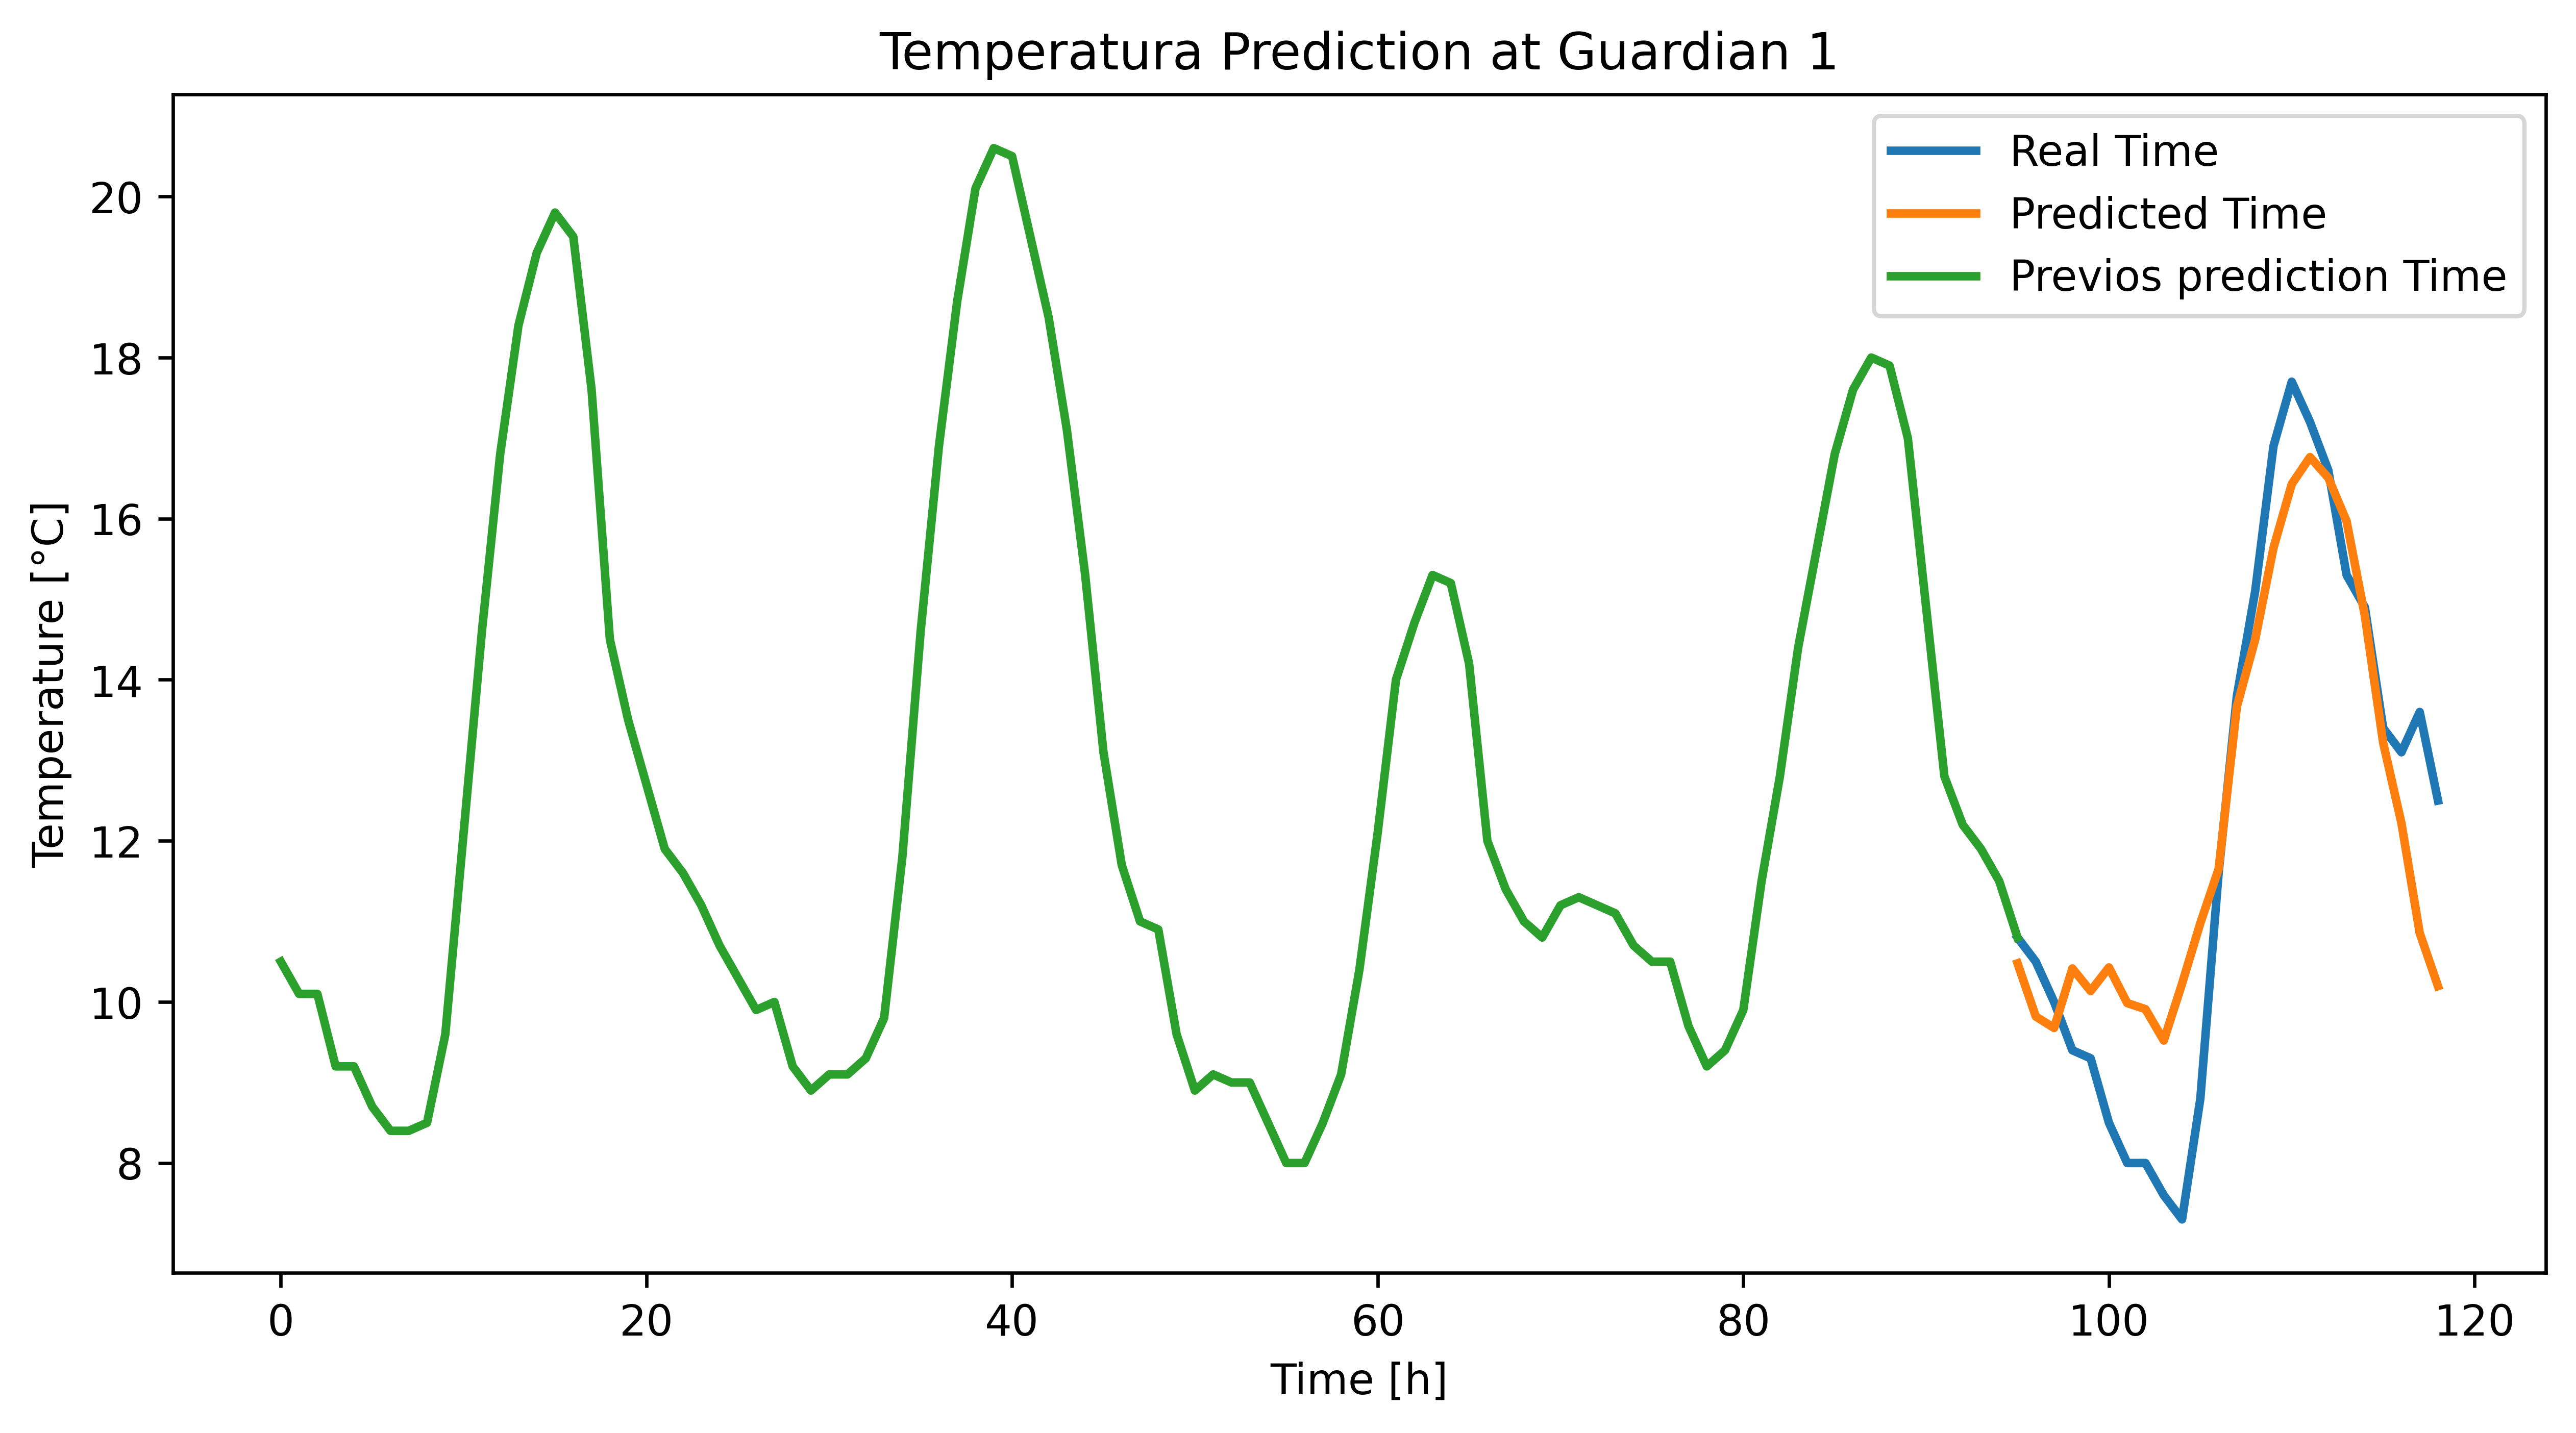

In [56]:
fig, ax = plt.subplots(figsize=(10, 5), dpi = 600)
ax.plot(temp_real, label = 'Real Time', lw = 2)
ax.plot(temp_pred, label = 'Predicted Time', lw = 2)
ax.plot(temp_before, label = 'Previos prediction Time', lw = 2)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Temperature [°C]')
ax.legend()
ax.set_title('Temperatura Prediction at Guardian 1')


In [43]:
torch_dataset[0].target.y

tensor([[[14.4000, 14.3664,  3.9000, 79.9000],
         [14.4000, 14.3680,  3.9000, 79.5000],
         [14.5000, 14.3604,  3.9000, 79.3000],
         [14.5000, 14.3542,  3.9000, 79.3000],
         [14.4000, 14.3577,  3.8000, 79.7000],
         [14.4000, 14.3620,  3.8000, 79.6000]],

        [[14.0000, 14.3699,  4.6000, 83.6000],
         [14.0000, 14.3714,  4.5000, 83.1000],
         [14.1000, 14.3639,  4.5000, 82.7000],
         [14.1000, 14.3577,  4.5000, 82.6000],
         [14.1000, 14.3612,  4.5000, 83.1000],
         [14.0000, 14.3654,  4.5000, 83.1000]],

        [[12.3000, 14.3696,  4.2000, 89.2000],
         [12.4000, 14.3711,  4.0000, 88.6000],
         [12.5000, 14.3636,  4.2000, 88.2000],
         [12.5000, 14.3575,  4.3000, 88.3000],
         [12.4000, 14.3611,  4.4000, 89.0000],
         [12.4000, 14.3652,  4.2000, 88.7000]],

        [[12.2000, 14.3727,  2.4000, 89.2000],
         [12.3000, 14.3742,  2.1000, 88.7000],
         [12.4000, 14.3666,  2.2000, 88.2000],
       